In [1]:
import matplotlib.animation as animation

from brian2 import *


### global parameters
defaultclock.dt = 15*ms


### simulation code
def run_sim_ou(N, K, A, Delta, omega_0, duration, random_seed=214040893):
    #start_scope()
    seed(random_seed)
    D = 0.5*Hz**2
    r = 1.0*second
    eqs = '''
    dTheta/dt = omega + K/N*coupling + noise: 1 #unit of theta not dtheta
    dnoise/dt = -noise/r + A*sqrt(D)/r: Hz
    omega : Hz(constant) # intrinsic frequency
    coupling : 1
    '''

    oscillators = NeuronGroup(N, eqs, method='euler')
    oscillators.Theta = np.random.rand(N)  # same initial phase angle

    
    oscillators.noise = 0.0 * Hz


    #CHANGE THIS TO ANOTHER VALUE
    lorentzian_omegas = omega_0 + Delta * np.tan(np.pi * (np.random.rand(N) - 0.5))
    #lorentzian_omegas = omega_0
    oscillators.omega = lorentzian_omegas


    connections = Synapses(oscillators, oscillators,
                        'coupling_post = sin(Theta_pre - Theta_post) : 1 (summed)')
    connections.connect()  # all-to-all

    mon = StateMonitor(oscillators, 'Theta', record=True)

   # Variable to hold the current value of z
    z_values = []
    @network_operation()
    def compute_z():
        # Calculate z(t) using the current phases
        z = np.mean(np.exp(1j * oscillators.Theta))
        z_values.append(z)

    net = Network(oscillators, connections, mon, compute_z)
    net.run(duration)

    return z_values

In [2]:
arr = [10.0, 3.5, 1.4]
sigma = 2*pi/(24) * Hz
Delta = sigma
Omega = arr[2] * sigma
omega_0 = sigma - Omega
min = 0
max = 100
time = 15 * second

maxAmplitude = 100 #max amplitude tested
synch_needed = []
amplitude = []
#Initializing amplitude values (linear with jumpstep 1)
for A in range(1, maxAmplitude + 1, 10) :
    amplitude.append(A)



for A in amplitude :
    min = 0
    max = 100
    while((max - min) >= 1e-2) :
        mid = (min+max)/2
        K  = mid * Hz
        z_final_ou = run_sim_ou(250, K, A, Delta, omega_0, time) #Can also test with 250 and 1000 just to verify result
        z_last_100_elements = z_final_ou[-100:]
        average_abs = np.mean(np.abs(z_last_100_elements))
        if(average_abs > 0.6):
            max = mid
        else: 
            min = mid
    print(A, min)
    synch_needed.append(min)


1 0.830078125
11 0.830078125
21 0.830078125
31 0.830078125
41 0.830078125
51 0.830078125
61 0.830078125
71 0.830078125
81 0.830078125
91 0.830078125


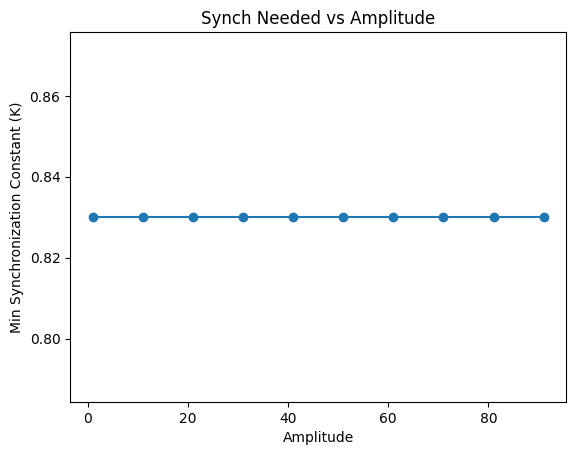

In [3]:
plt.plot(amplitude, synch_needed, marker='o', linestyle='-')

plt.xlabel("Amplitude of Noise")
plt.ylabel("Min Synchronization Constant (K)")
plt.title("Synch Needed vs Amplitude")

# Show the plot
plt.show()